[MatthewChatham]:https://github.com/MatthewChatham/glassdoor-review-scraper

<span style="color: red">*Work under development*</span>

<span style="font-size: 2em"> **Text Mining Facebook employees reviews** </span>

This work is an attempt at text mining employee reviews about Facebook posted on Glassdoor. How have major facebook events such as the 2012 IPO or the 2018 scandals affected company reviews?

Reviews were scraped thanks to the work of [Matthew Chatham][MatthewChatham], with the following command (executed 15/01/2019):

```zsh
python main.py --headless --url "https://www.glassdoor.com/facebook" --limit 10000 -f fb_reviews.csv
```

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
from nltk import FreqDist, NaiveBayesClassifier, pos_tag, bigrams, trigrams
from nltk.tokenize import word_tokenize
from nltk.classify import accuracy
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
np.random.seed(42)

# First look at the data

In [2]:
data = pd.read_csv('data/fb_reviews.csv', converters={"date":pd.to_datetime}).sort_values("date")
print('\nThere are {} reviews ranging from {} to {}. Example review below.\n'.
      format(data.shape[0], data.date.iloc[0].date(), data.date.iloc[-1].date()))
print(data.iloc[0,:])


There are 1625 reviews ranging from 2008-06-14 to 2019-01-14. Example review below.

date                                              2008-06-14 00:00:00
employee_title                                      Software Engineer
location                                                Palo Alto, CA
employee_status                                     Current Employee 
review_title                                                  Not bad
years_at_company                                                  NaN
helpful                                                             0
pros                    Cool environment, cool people. Stock options.
cons                Little to no opportunity for advancement, rais...
advice_to_mgmt                            Reward your employees more.
rating_overall                                                      3
rating_balance                                                      4
rating_culture                                                      1
rati

We now plot some basic series about the data.

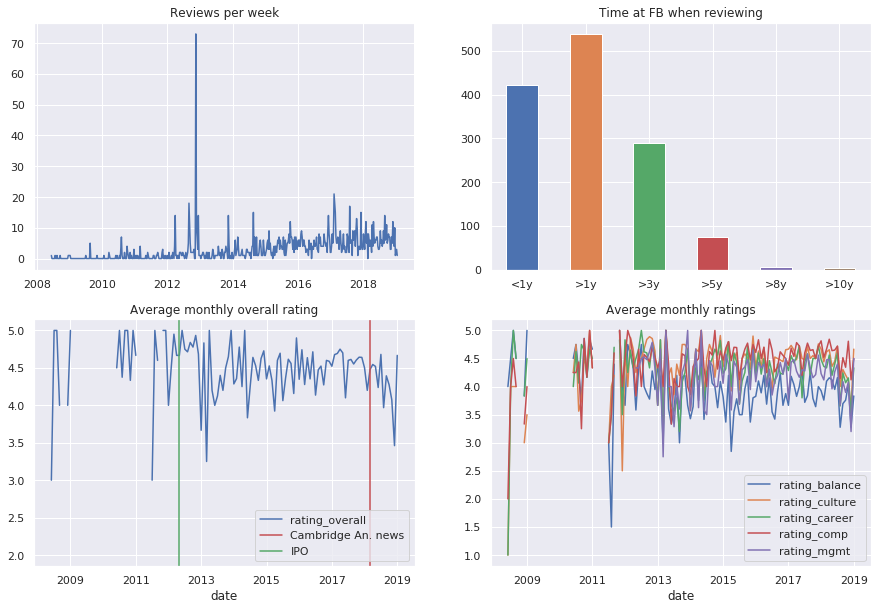

In [3]:
reviews_per_week = data['date'].value_counts().resample('W-SUN').sum()
time_at_fb = data['years_at_company'].dropna().value_counts().rename({"More than a year": ">1y",
                                                                      "Less than a year": "<1y",
                                                                      "More than 3 years": ">3y",
                                                                      "More than 5 years": ">5y",
                                                                      "More than 8 years": ">8y",
                                                                      "More than 10 years": ">10y",})
time_at_fb = time_at_fb.reindex([ '<1y', '>1y', '>3y', '>5y', '>8y', '>10y'])
overall_rating = data[['date', 'rating_overall']].set_index('date').resample('M').mean()
categories =['date', 'rating_balance', 'rating_culture', 'rating_career','rating_comp', 'rating_mgmt']
other_rating = data[categories].set_index('date').resample('M').mean()

f, axarr = plt.subplots(2, 2, figsize=(15,10))
reviews_per_week.plot(ax=axarr[0, 0], title='Reviews per week')
time_at_fb.plot(kind='bar', ax = axarr[0,1], title='Time at FB when reviewing')
axarr[0, 1].set_xticklabels(labels=time_at_fb.index, rotation=0)
# reviews_per_week.plot(kind='bar', ax = axarr[1,0])
overall_rating.plot(ax=axarr[1, 0], title='Average monthly overall rating')
axarr[1, 0].axvline('2018-03', c='r', label='Cambridge An. news')
axarr[1, 0].axvline('05-18-2012', c='g', label='IPO')
axarr[1, 0].legend()
other_rating.plot(ax=axarr[1, 1], title='Average monthly ratings');

The average number of rating per week varies but remains increasing throughout the period. The peak happens on the week ending 2012-11-18, roughly 6 months after their IPO. It is unclear what caused the sudden increase in reviews. It might be simply due to a company internal push.

About 70% of people review the company before having worked there for 3 years. Facebook was founded in 2004, so the few >10y reviews are credible. However we still have to keep in mind that all inforamtion besides the date is user-entered and prone to errors/being fictitious.

Overall rating is relatively high throughout the period, with a dip at the end of 2018 that was recovered in 2019. This decrease followed the Cambridge Analytica news.

Ratings for compensation and culture are constantly higher than rating for work/life balance. Management rating seems to have taken a hit during the second half of 2018.



# Into the Reviews
## Unigrams

We now have a closer look at the typed-in reviews, starting with a couple examples.

In [4]:
print('Example of a pro: \n  {}'.format(data.iloc[10]['pros']))
print('Example of a con: \n  {}'.format(data.iloc[10]['cons']))
print('Example of an advice to mgmt: \n  {}'.format(data.iloc[10]['advice_to_mgmt']))

Example of a pro: 
  3 meals + snack a day. Micro kitchens with fresh fruit, boxed lunches, and every beverage imaginable. All free. Flexible work hours, work from home, 21 days of PTO.
Example of a con: 
  In Palo Alto, CA -- a bit suburban for city dwellers.
Example of an advice to mgmt: 
  Keep it up!


We tokenize the sentence (separating the words from sentences), and let NLTK's pos_tag try its best at detecting what the words Part Of Speech are.

In [5]:
pros_tokens = [w.lower() for sent in data['pros'] for w in word_tokenize(sent)]
cons_tokens = [w.lower() for sent in data['cons'] for w in word_tokenize(sent)]
pros_tagged = pos_tag(pros_tokens)
cons_tagged = pos_tag(cons_tokens)
print('word: tag\n')
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in pros_tagged[:10]]))

word: tag

cool: JJ
environment: NN
,: ,
cool: JJ
people: NNS
.: .
stock: NN
options: NNS
.: .
fast: RB


### Most used nouns

In [6]:
pros_nn = FreqDist(w for (w,t) in pros_tagged if t in ['NN', 'NNS'])
print('The most used common nouns in the reviews pros are : \n')
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in pros_nn.most_common(15)]))
print('\n\nNote that the above and following outputs should be read as:\nword: # of occurences')

The most used common nouns in the reviews pros are : 

people: 874
company: 551
work: 498
i: 451
culture: 432
benefits: 388
perks: 363
facebook: 361
food: 298
environment: 222
impact: 216
world: 205
place: 204
lot: 183
team: 179


Note that the above and following outputs should be read as:
word: # of occurences


It is interesting to see that 'benefits', 'perks' and 'food' all take a higher place than 'impact' and 'world'.

In [7]:
cons_nn = FreqDist(w for (w,t) in cons_tagged if t in ['NN', 'NNS'])
print('The most used common nouns in the reviews cons are : \n')
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in cons_nn.most_common(15)]))

The most used common nouns in the reviews cons are : 

company: 392
people: 380
work: 337
i: 321
facebook: 210
balance: 182
time: 172
management: 155
lot: 154
life: 137
things: 136
culture: 136
team: 118
employees: 109
teams: 109


'Balance' is usually used in work-life balance. Seeing it here reinforces the idea that this is one of Fb's weaker points. It is interesting to see that culture is is both cons and pros, even though it appears much more often in pros.

### Most used adjectives

In [8]:
pros_jj = FreqDist(w for (w,t) in pros_tagged if t in ['JJ'])
print('The most used adjectives in the reviews pros are : \n')
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in pros_jj.most_common(15)]))

The most used adjectives in the reviews pros are : 

great: 734
good: 322
smart: 260
i: 219
free: 209
open: 201
amazing: 142
other: 140
awesome: 136
many: 129
high: 107
new: 91
much: 78
flexible: 68
strong: 67


Most of the adjectives above are uniformative on their own, but some are instructive: 'smart', free', 'open' and 'flexible' all speak to part of the culture at the company.

In [9]:
cons_jj = FreqDist(w for (w,t) in cons_tagged if t in ['JJ'])#, 'JJS', 'JJR'])
print('The most used adjectives in the reviews cons are : \n')
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in cons_jj.most_common(15)]))

The most used adjectives in the reviews cons are : 

good: 166
i: 150
much: 138
hard: 133
many: 126
great: 103
other: 103
high: 97
little: 77
long: 74
big: 70
new: 69
difficult: 63
bad: 55
work-life: 49


Again, most of the adjectives are uniformative when seen alone. This time, 'hard', 'difficult' and 'work-life' (miss-tagged by pos_tag) are interesting.

##  Bigrams

We now look at bigrams (group of two words) to see if we get a better sense of context.

In [10]:
unwanted = ".,!?;:-oftotheit'sayouisareondon'tandatinwithif'recanbewhofor"  # uninformative small words
pros_bi = FreqDist(bigrams([w for w in pros_tokens if w not in unwanted]))
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in pros_bi.most_common(15)]))

('smart', 'people'): 142
('free', 'food'): 117
('great', 'benefits'): 93
('place', 'work'): 80
('open', 'culture'): 63
('people', 'work'): 60
('great', 'perks'): 60
('every', 'day'): 51
('work', 'environment'): 48
('move', 'fast'): 48
('great', 'culture'): 46
('great', 'people'): 44
('great', 'place'): 40
('care', 'about'): 38
('people', 'great'): 36


In [11]:
cons_bi = FreqDist(bigrams([w for w in cons_tokens if w not in unwanted]))
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in cons_bi.most_common(15)]))

('work', 'life'): 85
('life', 'balance'): 83
('too', 'much'): 55
('work-life', 'balance'): 46
('work/life', 'balance'): 44
('long', 'hours'): 37
('there', 'no'): 33
('some', 'people'): 31
('too', 'many'): 27
('but', 'not'): 26
('menlo', 'park'): 26
('so', 'much'): 26
('rather', 'than'): 25
('no', 'one'): 25
('feel', 'like'): 25


## Trigrams

In [12]:
pros_tri = FreqDist(trigrams([w for w in pros_tokens if w not in unwanted]))
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in pros_tri.most_common(15)]))

('great', 'place', 'work'): 26
('work', 'life', 'balance'): 26
('as', 'long', 'as'): 22
('world', 'more', 'open'): 19
('more', 'open', 'connected'): 19
('smart', 'people', 'great'): 16
('some', 'smartest', 'people'): 15
('work', 'from', 'home'): 14
('really', 'smart', 'people'): 14
('q', '&', 'as'): 12
('weekly', 'q', '&'): 12
('breakfast', 'lunch', 'dinner'): 11
('making', 'world', 'more'): 11
('free', 'food', 'great'): 11
('smart', 'people', 'work'): 11


In [13]:
cons_tri = FreqDist(trigrams([w for w in cons_tokens if w not in unwanted]))
print('\n'.join(['{}: {}'.format(w[0], w[1]) for w in cons_tri.most_common(15)]))

('work', 'life', 'balance'): 75
('work', 'long', 'hours'): 9
('hard', 'keep', 'up'): 9
('company', 'has', 'grown'): 9
('as', 'company', 'grows'): 8
('think', 'any', 'cons'): 8
('move', 'so', 'fast'): 7
('this', 'not', 'place'): 7
('some', 'growing', 'pains'): 6
('great', 'place', 'work'): 6
('open', 'floor', 'plan'): 6
('commute', 'from', 'sf'): 6
('from', 'other', 'companies'): 6
('fast', 'break', 'things'): 6
('no', 'work', 'life'): 6


## A closer look at some keywords

In our previous results, it seemed that work/life balance appeared many times in the cons, but it also appeared in the pros. Has the distribution changed over time? What about other keywords?

In [14]:
def reviews_containing(word, col='pros'):
    """
    Searhes for all reviews constaining a str word. Note that only reviews containing exactly the str word as a 
      token are returned (i.e. no partial matches) 
    word: str
    return: pd.Series of all reviews in col containing word
    """
    out = data[col].loc[data[col].apply(lambda x: word in word_tokenize(x))]
    return out

In [15]:
def word_appearance(word):
    """
    Searches the number of mentions of a word in reviews through time
    word: str
    return: pd.DataFrame with columns: date, cum. # mentions of word in pros, cum. # mentions of word in cons
    """
    out = data[['date']].copy()
    out['pros'] = data['pros'].apply(lambda x: int(word in word_tokenize(x)))
    out['cons'] = data['cons'].apply(lambda x: int(word in word_tokenize(x)))
    out =  out.groupby('date').sum().cumsum()
    return out

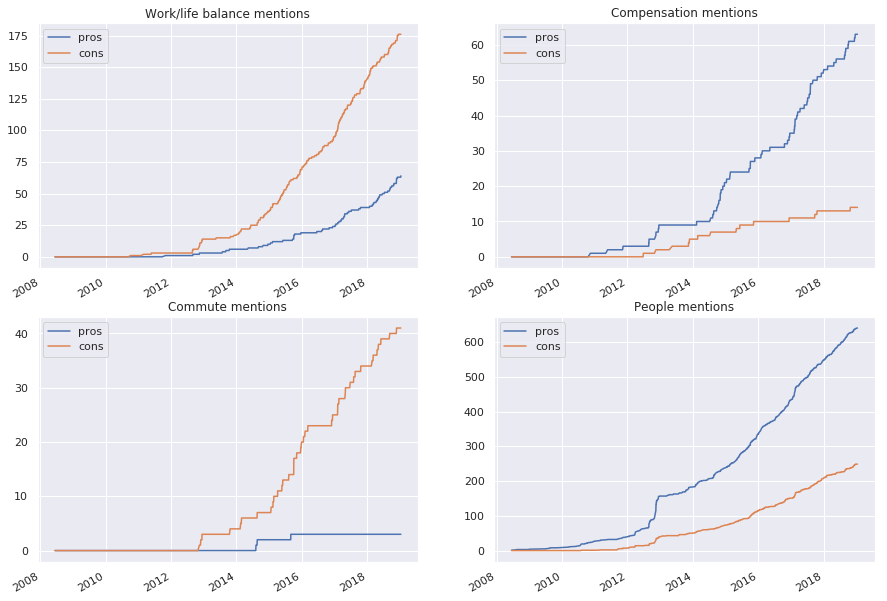

In [16]:
f, axarr = plt.subplots(2, 2, figsize=(15,11))
word_appearance('balance').plot(title='Work/life balance mentions', ax=axarr[0,0])
axarr[0,0].get_xaxis().get_label().set_visible(False)
word_appearance('compensation').plot(title='Compensation mentions', ax=axarr[0,1])
axarr[0,1].get_xaxis().get_label().set_visible(False)
word_appearance('commute').plot(title='Commute mentions', ax=axarr[1,0])
axarr[1,0].get_xaxis().get_label().set_visible(False)
word_appearance('people').plot(title='People mentions', ax=axarr[1,1])
axarr[1,1].get_xaxis().get_label().set_visible(False);

There was an increase in mentions of the word 'compensation' around 2015, possibly due to an actual increase in compensation.

Since the number of reviews jumped in november 2012, as we seen previously, increases in mentions around that time cannot be related to particular news or events. One could use a different metric: mentions per review. However, the increases in the above curves are not big enough to warrant finding anything interesting.

In [17]:
print(reviews_containing('people', 'cons').iloc[0])

Operations department management sucks, they don't treat to people in a respectful and fair way. If you want to be a good position in Operations, you need to be friend of some certain people.


# Classifying pros and cons

We here train a classifier to detect between pros and cons reviews. With a Naive Bayesian classifier, we will then have the weights for each word. This will could be useful in sentiment analysis.

The NaiveBayesClassifier as implemented in nltk is here used.

In [18]:
pros = [(word_tokenize(r.lower()), 'pros') for r in data['pros'].tolist()]
cons = [(word_tokenize(r.lower()), 'cons') for r in data['cons'].tolist()]
reviews_labelled = pros + cons
np.random.shuffle(reviews_labelled) 

In [19]:
all_words = FreqDist(w.lower() for w in pros_tokens + cons_tokens)
word_features = list(all_words)[:2000]  # 2000 most common words

def review_features(review): 
    review_words = set(review) 
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in review_words)
    return features

In [20]:
featuresets = [(review_features(d), c) for (d,c) in reviews_labelled]
train_set, test_set = featuresets[300:], featuresets[:300]  # test size: 300, train size: 1300
classifier = NaiveBayesClassifier.train(train_set)
print('Accuracy: {:.3f}\n'.format(accuracy(classifier, test_set)))
print(classifier.show_most_informative_features(10))

Accuracy: 0.853

Most Informative Features
          contains(cons) = True             cons : pros   =     30.3 : 1.0
    contains(supportive) = True             pros : cons   =     20.1 : 1.0
     contains(sometimes) = True             cons : pros   =     19.6 : 1.0
       contains(freedom) = True             pros : cons   =     19.4 : 1.0
         contains(perks) = True             pros : cons   =     17.9 : 1.0
     contains(inspiring) = True             pros : cons   =     17.4 : 1.0
      contains(friendly) = True             pros : cons   =     15.3 : 1.0
      contains(benefits) = True             pros : cons   =     15.3 : 1.0
       contains(amazing) = True             pros : cons   =     14.4 : 1.0
       contains(billion) = True             pros : cons   =     14.1 : 1.0
None


We achieve 85.3% accuracy, which is certainly not that bad for a first, naive approach. 

The word 'cons' is a strong indicator that the review is a cons review, which certainly makes things easy. It is interesting to see that 'sometimes' is also a strong indicator of a cons review. It seems that people tend to me more mitigated when writing negative reviews about facebook.  
The words weighting towards pros are, in a sense, less surprising: brilliant, supportive, perks...

# Extra analysis: when the reviews number jump

As we have seen in 1., the number of reviews jumped in the week ending 2012-11-18. This could lead one to believe that those reviews were incentivized by the company. One might also think this induced a bias. Let's see what we can find. 

In [21]:
idx = data['date'].between(pd.Timestamp('11-12-2012'), pd.Timestamp('11-18-2012'))
data['jump_week'] = data['date'].apply(lambda x: pd.Timestamp('11-11-2012') < x <= pd.Timestamp('11-18-2012'))
reviews_jump = data.loc[idx]
reviews_non_jump = data.loc[~idx]
print('{} reviews in the jump, {} others. Overall ratings during the jump were:\n{}'
      .format(reviews_jump.shape[0], reviews_non_jump.shape[0], reviews_jump['rating_overall'].values))

73 reviews in the jump, 1552 others. Overall ratings during the jump were:
[4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 5. 5. 5. 5. 5. 5.
 5.]


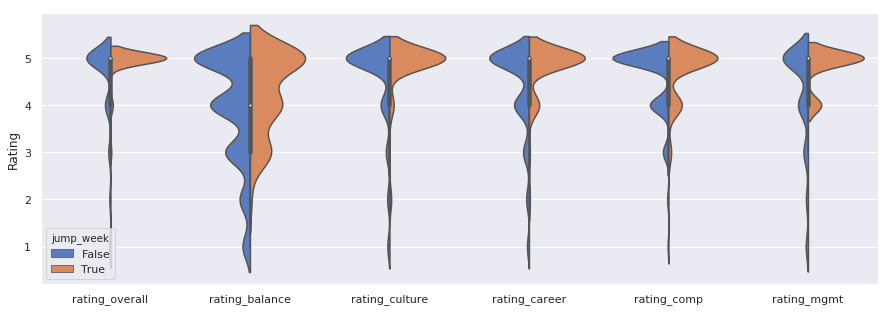

In [22]:
melting_subset_cols = ['rating_overall', 'rating_balance', 'rating_culture', 'rating_career',
                       'rating_comp', 'rating_mgmt', 'jump_week']  # plot help
plot_df = data[melting_subset_cols].melt(['jump_week'])

f, ax = plt.subplots(figsize=(15,5))
sns.violinplot(x="variable", y="value", hue="jump_week", data=plot_df, palette="muted", split=True, ax=ax)
ax.get_xaxis().get_label().set_visible(False)
ax.set_ylabel('Rating');

[chi2]:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

There does not seem much difference between jump_week and not jump_week distributions. To the naked eye, the bigggest discrepency is between overall rating distributions. During the jump, no overall rating lower than 3 was given, and the vast majority of them are 5s. Before and after the jump, overall ratings are also heavily skewed towrds 5s but less so.  We have to remind ourselves that one KDE is derived from 1552 observation while the other is drawn with a limited sample of 73 observations. 

We now statistically test whether those two rating_overall samples might have come from the same distribution with a Chi Square test (provided by [scipy][chi2]). We first need a helper function.

In [23]:
def rating_distribution(ratings):
    """
    rating: pd.Series of rating
    return [% of 1s, % of 2s, ..., % of 5s]
    """
    counts = ratings.value_counts()
    out = []
    for i in range(1,6):
        if i in counts.index:
            out.append(counts[i] / counts.sum()) 
        else:
            out.append(0)
    
    return out

In [24]:
chisquare(rating_distribution(reviews_jump['rating_overall']),
         rating_distribution(reviews_non_jump['rating_overall']))

Power_divergenceResult(statistic=0.2682776733194252, pvalue=0.9917688549894133)

The pvalue is well above the 5% threshold: we cannot reject the fact that both samples were generated for the same distribution. 